<a href="https://colab.research.google.com/github/96Asch/cv-bicycle-detection/blob/master/CV_Bike_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Bike detection using a Mask RCNN pretrained model
In this notebook we fine tune a Mask RCNN model, trained on the MSCOCO dataset, on our own created bike dataset. This dataset has already been pre-generated and is stored on a publicly accesible drive.

You can run the notebook in sequence except for when downgrading Keras. More instruction on this will be below.

#Install required packages

Here we clone the Mask RCNN repo and install the requirements from the given requirements.txt file

In [1]:
%cd
  
!git clone --quiet https://github.com/matterport/Mask_RCNN.git

/root


In [2]:
%cd ~/Mask_RCNN

!pip install -q PyDrive
!pip install -r requirements.txt
!pip install 'h5py<3.0.0'
!python setup.py install

/root/Mask_RCNN
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 154 kB 28.0 MB/s 
     |████████████████████████████████| 297 kB 47.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.9 MB 25.8 MB/s 
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'description-file' will not be supported in future versions. Please use the underscore name 'description_file' instead
  % (opt, underscore_opt))
/usr/local/lib/python3.7/dist-packages/setuptools/dist.py:700: UserWarning: Usage of dash-separated 'license-file' will not be supported in future versions. Please use the underscore name 'license_file' instead
  % (opt, u

#Download and extract dataset
This downloads the COCO_Bikes dataset from Google Drive and extracts it into Mask_RCNN/dataset/

In [6]:
%cd ~/Mask_RCNN


fileId = '14EAGfdRPSuIcrB3nmvXOfjtICFNALnMT'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

if not os.path.exists('./dataset'):
  os.makedirs('dataset')
os.chdir('dataset')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('./COCO_Bikes'):
  fileName = fileId + '.zip'
  downloaded = drive.CreateFile({'id': fileId})
  downloaded.GetContentFile(fileName)
  ds = ZipFile(fileName)
  ds.extractall()
  os.remove(fileName)
  print('Extracted zip file ' + fileName)


/root/Mask_RCNN


# Download the pretrained weights
We fetch the MSCOCO pretrained weights of Mask RCNN


In [4]:
%cd ~

modelId = '1Mos_U0jPpmNleZuLzGSTRTp7Ct4-PdAK'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('./pretrained.h5'):
  downloaded = drive.CreateFile({'id': modelId})
  downloaded.GetContentFile('pretrained.h5')

/root


#Configure the the Config and Dataset 

The Config class handles the configuration of the training.
The Dataset class handles the import of our custom dataset

In [4]:
%cd ~/Mask_RCNN
%tensorflow_version 1.x
import os
import argparse
import tensorflow as tf
import datetime
import warnings

import numpy as np
from pycocotools.coco import COCO
import sys


from mrcnn.config import Config
from mrcnn import utils

sys.path.append(os.path.join("/root/Mask_RCNN", "samples/coco/"))  # To find local version
import coco

class DelftBikesConfig(Config):
    NAME = "delft-bikes"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 1 + 1  # background + bike
    STEPS_PER_EPOCH = 100
    LEARNING_RATE = 0.0001
  

class COCODelftBikes(coco.CocoDataset):

    def load(self, dataset_dir: str, subset: str) -> None:

        path = os.path.join(dataset_dir, subset)
        annotation = os.path.join(dataset_dir, f"{subset}.json")

        coco = COCO(annotation)
        class_ids = sorted(coco.getCatIds())
        
        image_ids = []
        for id in class_ids:
            image_ids.extend(list(coco.getImgIds(catIds=[id])))
        # Remove duplicates
        image_ids = list(set(image_ids))

        self.add_class("coco", 1, coco.loadCats(1)[0]["name"])
        
        
          # Add images
        for i in image_ids:
            self.add_image(
                "coco", image_id=i,
                path=os.path.join(path, coco.imgs[i]['file_name']),
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))

    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "coco":
            return super(coco.CocoDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = annotation['category_id']
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            return mask, np.ones([mask.shape[-1]], dtype=np.uint8)
        else:
            # Call super class to return an empty mask
            return super(coco.CocoDataset, self).load_mask(image_id)

/root/Mask_RCNN


###  Check if the GPU is running

In [14]:
%tensorflow_version 1.x



import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Train the model
Here we begin training the model, by first enabling Tensorboard in order to visualize each loss later on.

In [7]:
%load_ext tensorboard

#### Re-install the correct version of Keras
For some reason, the built-in version of Keras gets reset when using the tensorflow version command. So we install the correct version: 2.2.5.
You must reset the runtime to change the versions. Then re-run the config and dataset cell before continuing.

In [3]:
!pip install keras==2.2.5
!pip list | grep Keras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached Keras-2.2.5-py2.py3-none-any.whl (336 kB)
  Attempting uninstall: keras
    Found existing installation: keras 2.8.0
    Uninstalling keras-2.8.0:
      Successfully uninstalled keras-2.8.0
Keras                         2.2.5
Keras-Applications            1.0.8
Keras-Preprocessing           1.1.2


We load the pretrained model and begin training using the dataset and config files specified before

In [31]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", category=DeprecationWarning) 
import mrcnn.model as modellib

config = DelftBikesConfig()
model_save_dir = os.path.join("/content", "exps")
pretrained_model_file = os.path.join("/root", "pretrained.h5")
data_set_dir = os.path.join("/root", "Mask_RCNN", "dataset", "COCO_Bikes")

with tf.device(device_name):
    model = modellib.MaskRCNN(mode='training', config=config, model_dir=model_save_dir)

assert os.path.exists(pretrained_model_file)
    
model.load_weights(pretrained_model_file, by_name=True, exclude=[ "mrcnn_class_logits", "mrcnn_bbox_fc", "mrcnn_bbox", "mrcnn_mask"])

dataset_train = COCODelftBikes()
dataset_train.load(data_set_dir, 'train')
dataset_train.prepare()

dataset_val = COCODelftBikes()
dataset_val.load(data_set_dir, 'test')
dataset_val.prepare()

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            epochs=100,
            layers='all')


loading annotations into memory...
Done (t=0.38s)
creating index...
index created!
loading annotations into memory...
Done (t=0.05s)
creating index...
index created!

Starting at epoch 0. LR=0.0001

Checkpoint Path: /content/exps/delft-bikes20220616T2223/mask_rcnn_delft-bikes_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branc

KeyboardInterrupt: ignored

# Visualize the losses using TensorBoard
You should edit the path after --logdir and put the path to folder created by Mask RCNN which contains the tfevents file

In [ ]:
%tensorboard --logdir /root/exps/delft-bikes20220615T2029

# Download the ValBikes Dataset


In [11]:
%cd ~/Mask_RCNN

fileId = "1tSvhZRYZPLuRN3_m8alXstgqgppoLj04"

if not os.path.exists('./dataset'):
  os.makedirs('dataset')
os.chdir('dataset')

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('./ValBikes'):
  fileName = fileId + '.zip'
  downloaded = drive.CreateFile({'id': fileId})
  downloaded.GetContentFile(fileName)
  ds = ZipFile(fileName)
  ds.extractall()
  os.remove(fileName)
  print('Extracted zip file ' + fileName)

/root/Mask_RCNN
Extracted zip file 1tSvhZRYZPLuRN3_m8alXstgqgppoLj04.zip


# Download the two fine-tuned models
Here we will retrieve the models that were fine-tuned on our augmented dataset, one model was trained with the default LR=0.001 and the other with a LR=0.0001

In [7]:
%cd ~

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth

maskLR0001_id = '1ClTIBdFRNMLb9utSMjOEGh7s9Uci76Y2'
maskLR00001_id = '11VD9mWNN9YK8ZI4Rm2myDLRVAC1EUv_z'

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

if not os.path.exists('./maskLR0001.h5'):
  downloaded = drive.CreateFile({'id': maskLR0001_id})
  downloaded.GetContentFile('maskLR0001.h5')

if not os.path.exists('./maskLR00001.h5'):
  downloaded = drive.CreateFile({'id': maskLR00001_id})
  downloaded.GetContentFile('maskLR00001.h5')

/root


# Run tests on the three models
For these tests, we will calculate the mean average precision (mAP) and the mean intersection over union (mIOU). Luckily, Mask RCNN already provides us with these metrics in the utils file.

In [78]:
class InferenceConfigAllClass(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 81

class InferenceConfigBikeClass(coco.CocoConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    NUM_CLASSES = 2


class ValBikes(coco.CocoDataset):

    def load(self, dataset_dir: str) -> None:

        path = os.path.join(dataset_dir, "val")
        annotation = os.path.join(dataset_dir, "TestBikes.json")

        coco = COCO(annotation)
        class_ids = sorted(coco.getCatIds())
        
        image_ids = []
        for id in class_ids:
            image_ids.extend(list(coco.getImgIds(catIds=[id])))
        # Remove duplicates
        image_ids = list(set(image_ids))

        self.add_class("coco", 2, coco.loadCats(1)[0]["name"])
        
          # Add images
        for i in image_ids:
            self.add_image(
                "coco", image_id=i,
                path=os.path.join(path, coco.imgs[i]['file_name']),
                width=coco.imgs[i]["width"],
                height=coco.imgs[i]["height"],
                annotations=coco.loadAnns(coco.getAnnIds(
                    imgIds=[i], catIds=class_ids, iscrowd=None)))

    def load_mask(self, image_id):
        """Load instance masks for the given image.
        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].
        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "coco":
            return super(coco.CocoDataset, self).load_mask(image_id)

        instance_masks = []
        class_ids = []
        annotations = self.image_info[image_id]["annotations"]
        # Build mask of shape [height, width, instance_count] and list
        # of class IDs that correspond to each channel of the mask.
        for annotation in annotations:
            class_id = annotation['category_id']
            if class_id:
                m = self.annToMask(annotation, image_info["height"],
                                   image_info["width"])
                # Some objects are so small that they're less than 1 pixel area
                # and end up rounded out. Skip those objects.
                if m.max() < 1:
                    continue
                # Is it a crowd? If so, use a negative class ID.
                if annotation['iscrowd']:
                    # Use negative class ID for crowds
                    class_id *= -1
                    # For crowd masks, annToMask() sometimes returns a mask
                    # smaller than the given dimensions. If so, resize it.
                    if m.shape[0] != image_info["height"] or m.shape[1] != image_info["width"]:
                        m = np.ones([image_info["height"], image_info["width"]], dtype=bool)
                instance_masks.append(m)
                class_ids.append(class_id)

        # Pack instance masks into an array
        if class_ids:
            mask = np.stack(instance_masks, axis=2).astype(np.bool)
            return mask, np.ones([mask.shape[-1]], dtype=np.uint8)
        else:
            # Call super class to return an empty mask
            return super(coco.CocoDataset, self).load_mask(image_id)

In [37]:
%cd ~/Mask_RCNN
%tensorflow_version 1.x
import os
import tensorflow as tf
import warnings
import mrcnn.model as modellib
import numpy as np
from pycocotools.coco import COCO

model_save_dir = os.path.join('/content', 'model')
baseline_model_file = os.path.join("/root", "pretrained.h5")
lr0001_model_file = os.path.join("/root", "maskLR0001.h5")
lr00001_model_file = os.path.join("/root", "maskLR00001.h5")

allClassConfig = InferenceConfigAllClass()
bikeClassConfig = InferenceConfigBikeClass()

with tf.device(device_name):
    baseline = modellib.MaskRCNN(mode='inference', config=allClassConfig, model_dir=model_save_dir)
    model_LR0001 = modellib.MaskRCNN(mode='inference', config=bikeClassConfig, model_dir=model_save_dir)
    model_LR00001 = modellib.MaskRCNN(mode='inference', config=bikeClassConfig, model_dir=model_save_dir)

baseline.load_weights(baseline_model_file, by_name=True)
model_LR0001.load_weights(lr0001_model_file, by_name=True)
model_LR00001.load_weights(lr00001_model_file, by_name=True)    

/root/Mask_RCNN


In [79]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

coco_class_names = ['BG', 'person', 'bicycle', 'car', 'motorcycle', 'airplane',
               'bus', 'train', 'truck', 'boat', 'traffic light',
               'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird',
               'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear',
               'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie',
               'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
               'kite', 'baseball bat', 'baseball glove', 'skateboard',
               'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup',
               'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple',
               'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
               'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed',
               'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
               'keyboard', 'cell phone', 'microwave', 'oven', 'toaster',
               'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
               'teddy bear', 'hair drier', 'toothbrush']

In [80]:
from mrcnn import utils

data_set_dir = os.path.join("/root", "Mask_RCNN", "dataset", "ValBikes")

valbikes = ValBikes()
valbikes.load(data_set_dir)
valbikes.prepare()

# coco_dataset = coco.CocoDataset()
# coco_dataset.load_coco(os.path.join("/root", "Mask_RCNN", "dataset", "COCO"), "minival", auto_download=True)

# # Must call before using the dataset
# coco_dataset.prepare()


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Will use images in /root/Mask_RCNN/dataset/COCO/val2014
Will use annotations in /root/Mask_RCNN/dataset/COCO/annotations/instances_minival2014.json
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


##Calculate the mAP

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[1 1]


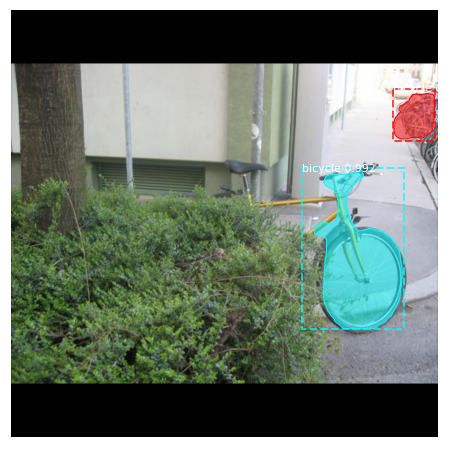

[0.0]


In [106]:
from tqdm import tqdm
from mrcnn import visualize 

APs = []
# for image_id in tqdm(valbikes.image_ids):

    # Load image and ground truth data
image, _, gt_class_id, gt_bbox, gt_mask = \
    modellib.load_image_gt(valbikes, bikeClassConfig, 5, use_mini_mask=False)

# Run object detection
results = model_LR00001.detect([image], verbose=1)
r = results[0]

ids = np.array([2 if id == 1 else id for id in r["class_ids"]])

# Compute AP
AP, precisions, recalls, overlaps = \
    utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                      r["rois"], r["class_ids"], r["scores"], r['masks'])
APs.append(AP)
print(r["class_ids"])

visualize.display_instances(image, r["rois"], r['masks'], ids, 
                            coco_class_names, r["scores"], figsize=(8, 8))


print(APs)

In [103]:
print(APs)

[0.0]
